In [1]:
%matplotlib inline
import os
import shutil
import math
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [2]:
stats = pd.read_csv('/media/NGS/Sequence/Neisseria_lactamica/Basic_Stats.csv')

stats = stats.fillna('')
stats = stats[~stats['Platform'].str.contains('Ion')]

In [6]:
identify = pd.read_csv('/media/NGS/Sequence/Neisseria_lactamica/Identify.csv', index_col=0)
identify = identify[identify['Species'] == 'Neisseria lactamica']
identify = identify[(identify['Query_Coverage']>=50)&(identify['Template_Coverage']>=50)]

table = stats[stats['Assembly'].isin(identify.index)]
table.shape

(1099, 10)

# Combine metadata selection

In [7]:
def fence(df, subset):
    std = df[subset].std()
    mean = df[subset].mean()
    return (df[subset]>(mean - 2*std))&(df[subset]<(mean + 2*std))

<ipython-input-8-4436f2a66927>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['outlier'] = ~(fence(table, 'GC%') & fence(table, 'Size(MB)'))


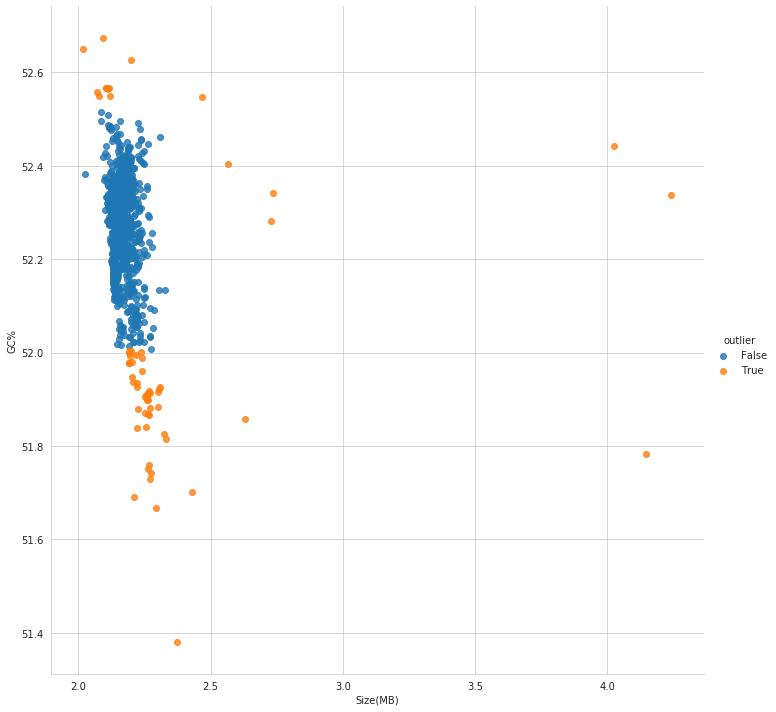

In [8]:
table['outlier'] = ~(fence(table, 'GC%') & fence(table, 'Size(MB)'))

sns.lmplot(data=table, x="Size(MB)", y="GC%", fit_reg=False, height=10, hue='outlier')

In [59]:
curated = table[~table['outlier']]
curated.shape

(1035, 11)

# N50

Text(0, 0.5, 'number')

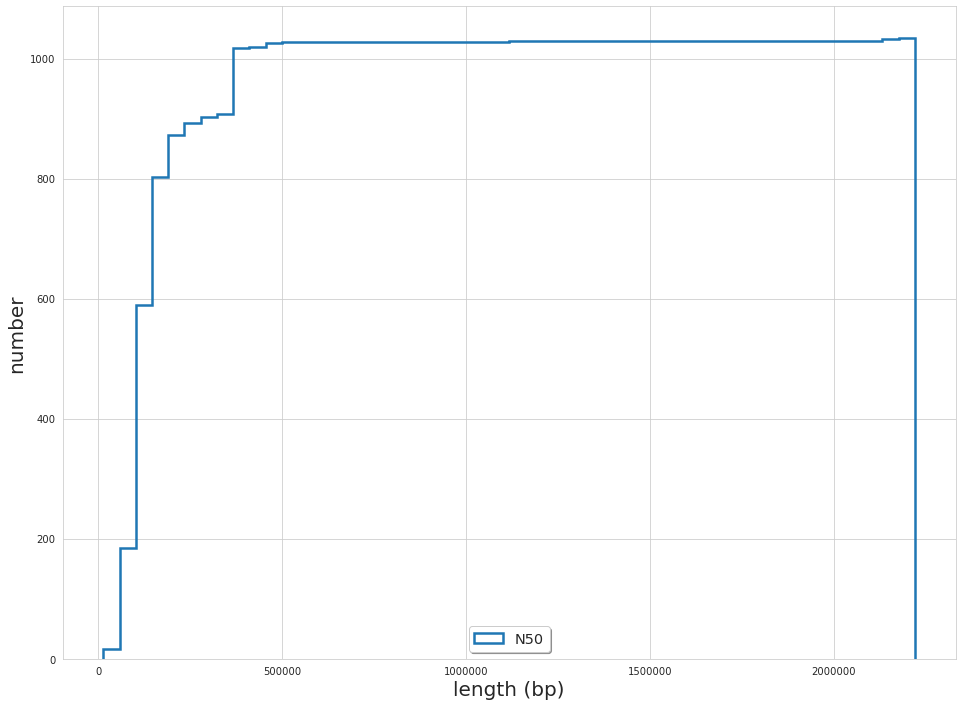

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["N50"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.legend(loc='lower center', shadow=True, fontsize='x-large')
plt.xlabel("length (bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

Text(0, 0.5, 'number')

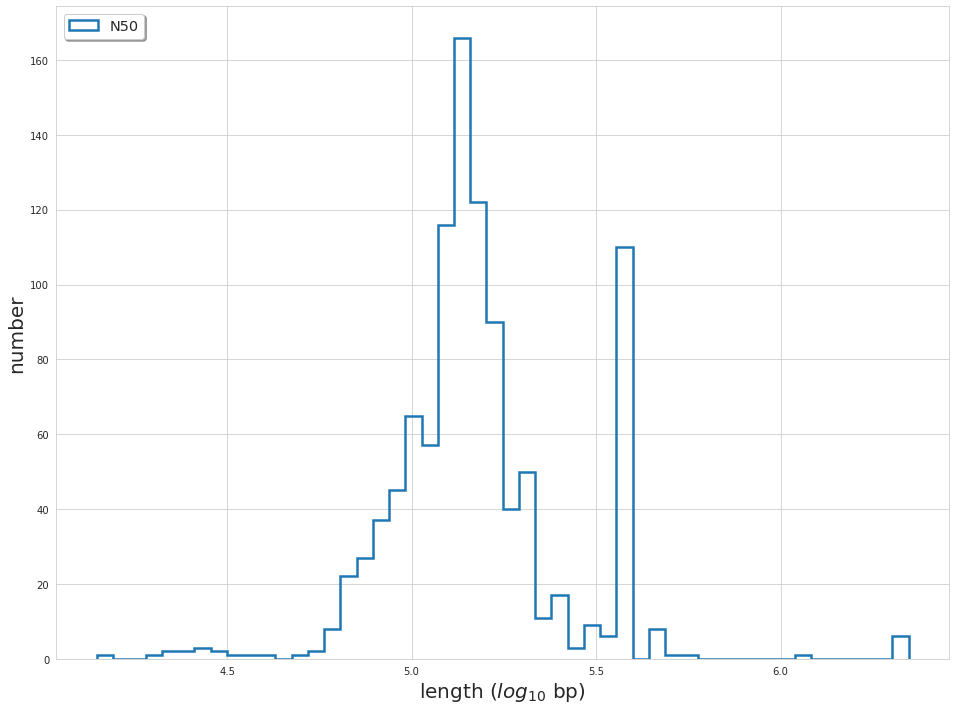

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(np.log10(curated["N50"]), bins=50, histtype="step", lw=2.5, label="N50")
ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel("length ($log_{10}$ bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

# comparison with serotypes

In [71]:
hist, bin_edges = np.histogram(np.log10(curated["N50"]), bins=100)
threshold = sorted(list(zip(hist, bin_edges)), key=lambda x: x[0], reverse=True)[0][1]
threshold

5.558358156179785

In [72]:
curated = curated[curated['N50'] >= 10 ** threshold]
curated.shape

(127, 11)

Text(0.5, 1.0, 'Genome contig number distribution')

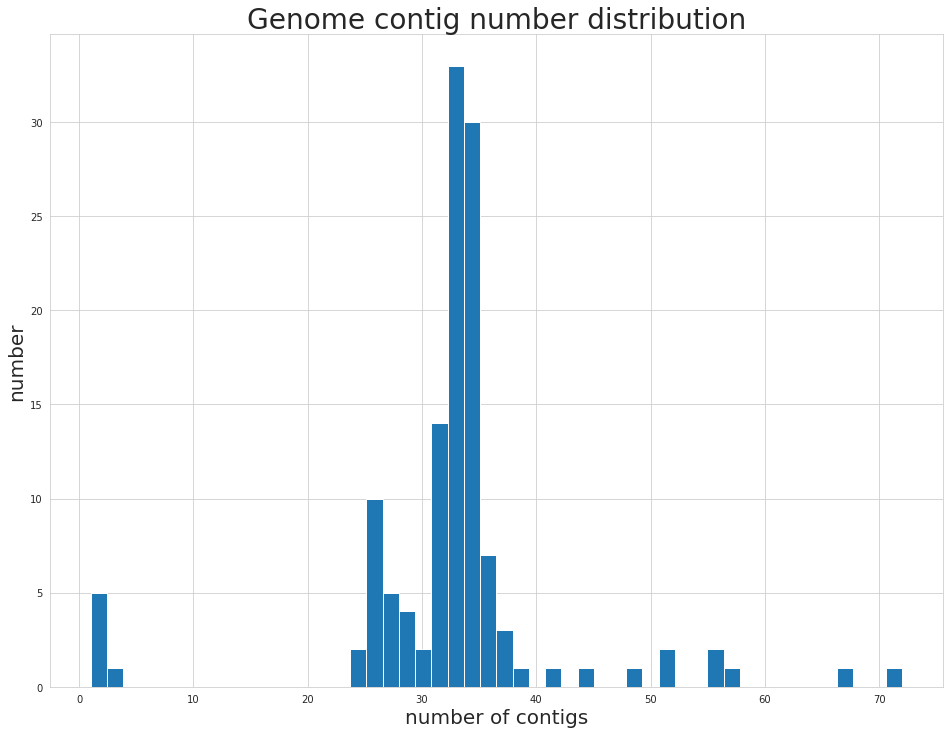

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["num_seqs"], bins=50)
plt.xlabel("number of contigs", fontsize=20)
plt.ylabel("number", fontsize=20)
plt.title("Genome contig number distribution", fontsize=28)

In [22]:
from_dir = '/media/NGS/Sequence/Neisseria_lactamica/NCBI'
to_dir = '/media/NGS/Sequence/Neisseria_lactamica/NCBI_clean/'

In [30]:
for filename in os.listdir(from_dir):
    if os.path.splitext(filename)[0] in set(curated['Assembly']):
        shutil.copy(os.path.join(from_dir, filename), os.path.join(to_dir, os.path.splitext(filename)[0] + '.fa'))